In [2]:
#base
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random
#keras
import keras.backend as K
import tensorflow as tf 
#sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
#scipy
from scipy.spatial import distance
from scipy.stats import gmean
from scipy import interpolate 
#biopython
import skbio
from io import StringIO

In [3]:
warnings.filterwarnings('ignore')
sns.set_theme()

In [8]:
%cd ..

/home/MCB/zkarwowska/AE


In [9]:
df = pd.read_csv('rarefied_double_interpolated_feces_male_otu.csv', index_col = [0])
x_train = df.iloc[:220]
x_test = df.iloc[221:]

In [10]:
def filter_rare_bacteria(df):
    
    rare_bacteria_df = pd.DataFrame((df == 0).astype(int).sum(axis = 0))
    rare_bacteria_col = rare_bacteria_df[rare_bacteria_df[0] > 250].index
    df_filtered = df.drop(rare_bacteria_col, axis = 1)
    
    return df_filtered

In [11]:
filtered_df = filter_rare_bacteria(df)
#filtered_df.to_csv('improve_latent/filtered_data.csv')

In [12]:
x_train = filtered_df.iloc[:220]
x_test = filtered_df.iloc[221:]

In [ ]:
#x_train.to_csv('correct_prediction/rclr_data_xtrain.csv', sep = '\t')

In [13]:
scaler = MinMaxScaler()

normalized_train = scaler.fit_transform(x_train)
normalized_test = scaler.transform(x_test)

In [15]:
input_size = normalized_train.shape[1]

#zolta i czarna : wejscie surowe dane
input_data_1 = tf.keras.Input(shape=(input_size,))
#zielona: wejscie do enkodera 
input_data_2 = tf.keras.Input(shape=(input_size,))
#input tylko do sciezki zoltej
input_svar = tf.keras.Input(shape=(input_size,))
#
first_layer = tf.keras.layers.Dense(512, activation='relu')

#zolta i czarna   e1
encoded_1 = first_layer(input_data_1)
#zielona e1
encoded_2 = first_layer(input_data_2)
#zolta
encoded_svar = first_layer(input_svar)

#latent
second_layer = tf.keras.layers.Dense(64)
#zolta i czarna 
latent_1 = second_layer(encoded_1)
#zielona
latent_2 = second_layer(encoded_2)
#zolta
latent_svar = second_layer(encoded_svar)


#input czerwony: placeholder na latent
#input_decoder = tf.keras.layers.Input(64)
#svar layer - linear a and regularization - dokladamy glowe svar
svar_layer_1 = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))
#reduction : sciezka zolta + czarna (ramie zolte)
#tylko redukcja dla siezka zolta + czarna
latent_svar_train = svar_layer_1(latent_1)
#redukcja tylko dla zoltej
latent_svar_pred = svar_layer_1(latent_svar)

latent_svar_encoded = svar_layer_1(latent_2)
#reconstruction decoder
first_decoder = tf.keras.layers.Dense(512, activation='relu')

#sciezka zolta + czarna zwykla rekonstrukcja (ramie czarne): tylko do trenowania
decoder_1 = first_decoder(latent_1)
#sciezka zolta + czarna  (ramie zolte) zolta: rekonstrukcja predykcji do treningu 
decoder_svar = first_decoder(latent_svar_train)
#czerwona 
#decoder = first_decoder(input_decoder)
#tylko zolta rekon. predykcji 
decoder_svar_pred = first_decoder(latent_svar_pred)

#sciezka czarna: zwykla rekonstrukcja (input: t)
output1 = tf.keras.layers.Dense(input_size, activation='linear')(decoder_1)
#sciezka zolta: rekon. predykcji  (input: t+1)
output_svar = tf.keras.layers.Dense(input_size, activation='linear')(decoder_svar)
#sciezka czerwona: nie ternujemy, do dekodera
#output = tf.keras.layers.Dense(input_size, activation='linear')(decoder)

output_svar_pred = tf.keras.layers.Dense(input_size, activation='linear')(decoder_svar_pred)

# Compile model
#zolty i czarny: rekon zwykla i predykcji 
svar_autoencoder = tf.keras.Model(input_data_1, [output1, output_svar])
#zolta 
svar_model = tf.keras.Model(input_svar, output_svar_pred)
#decoder_model = tf.keras.Model(input_decoder, output)

#mse dla rekon i predykcji
svar_autoencoder.compile(
    loss = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError()],
    loss_weights = [1.0, 60.0],
    optimizer='Adam'
)

#autoencoder = tf.keras.Model(input_data_1, output1)
#enkoder tylko redukcja do 64
encoder = tf.keras.Model(input_data_2, [latent_2, latent_svar_encoded])

ae_result = svar_autoencoder.fit(
    normalized_train[:-1], [normalized_train[:-1], normalized_train[1:]],
    epochs=150,
    batch_size=16,
    shuffle=False,
verbose = 0)

results_df = pd.DataFrame.from_dict(ae_result.history)
results_df['epochs'] = results_df.index

In [16]:
svar_autoencoder.save('svar_autoenkoder.h5')

In [17]:
svar_autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 347)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 512)          178176      ['input_4[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 64)           32832       ['dense_7[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 64)           4160        ['dense_8[0][0]']                
                                                                                            

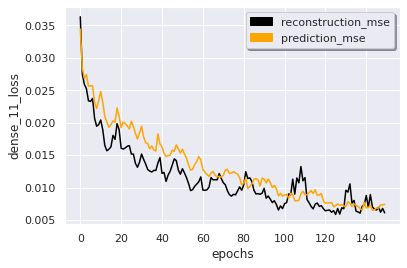

In [19]:
sns.lineplot(x = results_df['epochs'], y = results_df['dense_11_loss'], color = 'black')
sns.lineplot(x = results_df['epochs'], y = results_df['dense_12_loss'], color = 'orange')

import matplotlib.patches as mpatches

black_path = mpatches.Patch(color='black', label='reconstruction_mse')
orange_path = mpatches.Patch(color='orange', label='prediction_mse')
plt.legend(handles=[black_path, orange_path], shadow = True)

#plt.savefig('ae_svar/svar_ae_reconstruction_prediction_mse.png')

# encoder

In [20]:
ae = tf.keras.models.load_model('svar_autoenkoder.h5')

encoder_model = tf.keras.Model(ae.input, ae.layers[-3].output)

encoded_array = encoder_model.predict(normalized_train)
encoded_df = pd.DataFrame(encoded_array)

#encoded_df.to_csv('improve_latent/relu_filtered_data.csv', sep = '\t')

In [21]:
#encoded_df.to_csv('improve_latent/encoded_for_svar.csv', sep = '\t')

# svar predicted

In [21]:
history = x_train[1:]
history_df = pd.DataFrame(history, columns = filtered_df.columns)

prediction = ae.predict(normalized_train)[1] #[0] rekon,  [1] predykcja 
prediction_denorm = scaler.inverse_transform(prediction)
prediction_df = pd.DataFrame(prediction_denorm, columns = filtered_df.columns)
prediction_df = prediction_df.iloc[:-1]
prediction_df.index = history_df.index
prediction_df[prediction_df <0] = 0

pred_recon = ae.predict(normalized_train)[0]
pred_recon_denorm = scaler.inverse_transform(pred_recon)
prediction_recon_df = pd.DataFrame(pred_recon_denorm, columns = filtered_df.columns)

In [15]:
history_df.to_csv('ae_svar/history_train.csv')
prediction_df.to_csv('ae_svar/prediction_train.csv')

In [22]:
def plot_prediction(col):
    
    plt.figure(figsize =  [ 20, 10])

    ax = sns.lineplot(x = history_df.index, y = history_df[col], color = 'Black', linewidth = .8, linestyle = '--')
    sns.scatterplot(x = history_df.index, y = history_df[col], color = 'Black', alpha = .7)

    sns.lineplot(x = history_df.index, y = prediction_df[col], color = 'Orange', linewidth = .8)
    sns.scatterplot(x = history_df.index, y = prediction_df[col], color = 'Orange', alpha = .7)

    plt.ylabel('sample_otu', fontsize=16)
    plt.title("SVAR_AE model's prediction for sample otu")
    plt.show()
    #plt.savefig('ae_svar/ae_sample_prediction2.png')

#sns.lineplot(x = history_df.index, y = prediction_recon_df[col], color = 'Green')
#sns.scatterplot(x = history_df.index, y = prediction_recon_df[col], color = 'Green')

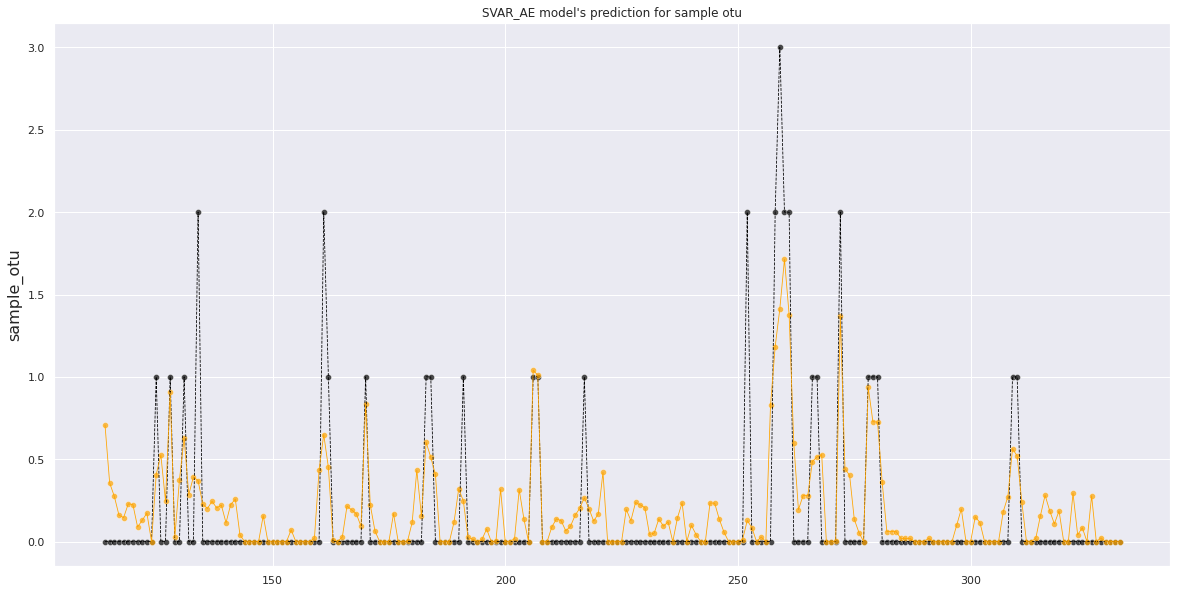

In [23]:
plot_prediction('TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGC')

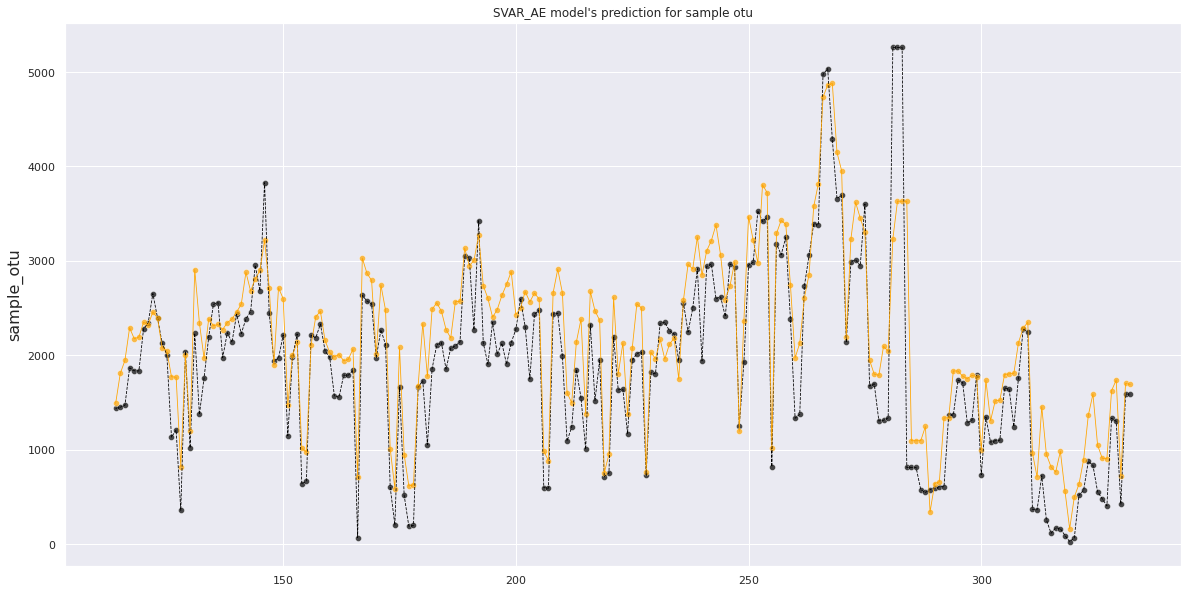

In [105]:
plot_prediction('TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGACGCTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG')

In [81]:
encoding, svar_encoding = encoder.predict(normalized_train)

In [82]:
full_encoding = np.concatenate([encoding, svar_encoding], axis = 0)

In [83]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(full_encoding)

PCA()

In [85]:
encoding_transformed = pca.transform(encoding)
encdoing_svar_transformed = pca.transform(svar_encoding)


<AxesSubplot:ylabel='Count'>

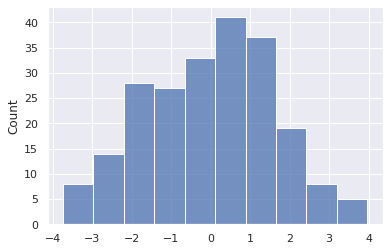

In [86]:
sns.histplot(encoding_transformed[:, 3])

<AxesSubplot:ylabel='Count'>

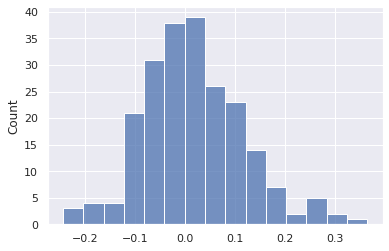

In [87]:
sns.histplot(encdoing_svar_transformed[:, 3])

<AxesSubplot:>

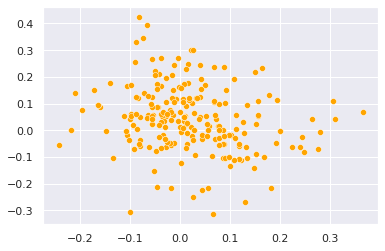

In [89]:
#sns.scatterplot(encoding_transformed[:, 3], encoding_transformed[:, 4], color = 'grey')
sns.scatterplot(encdoing_svar_transformed[:, 3], encdoing_svar_transformed[:, 4], color = 'orange')

<AxesSubplot:>

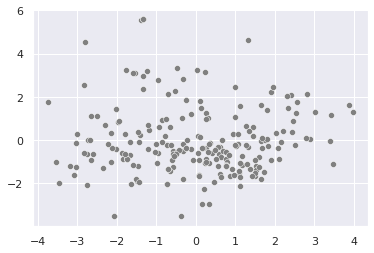

In [90]:
sns.scatterplot(encoding_transformed[:, 3], encoding_transformed[:, 4], color = 'grey')